<a href="https://colab.research.google.com/github/Nagalakshmigithub62/NLP/blob/main/NLPCW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import string
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/train.txt', sep='\t')  # Ensure to use the correct delimiter if it's not comma

In [ ]:
data.head()

,id,turn1,turn2,turn3,label
0,0,Don't worry I'm girl,hmm how do I know if you are,What's ur name?,others
1,1,When did I?,saw many times i think -_-,No. I never saw you,angry
2,2,By,by Google Chrome,Where you live,others
3,3,U r ridiculous,I might be ridiculous but I am telling the truth.,U little disgusting whore,angry
4,4,Just for time pass,wt do u do 4 a living then,Maybe,others


In [ ]:
data['label'].value_counts()

label
others    14948
angry      5506
sad        5463
happy      4243
Name: count, dtype: int64

In [ ]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30160 entries, 0 to 30159
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30160 non-null  int64 
 1   turn1   30157 non-null  object
 2   turn2   30160 non-null  object
 3   turn3   30160 non-null  object
 4   label   30160 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.2+ MB
None


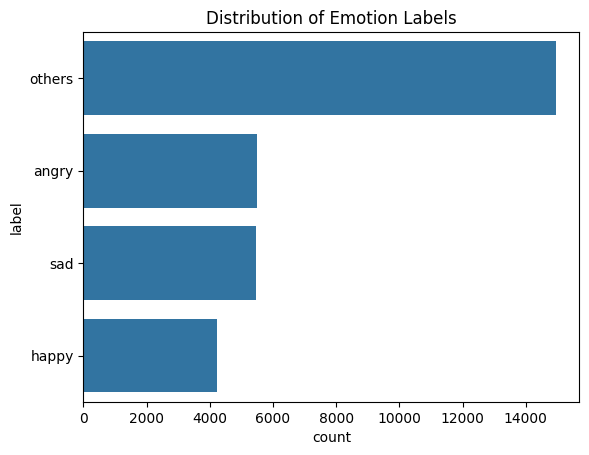

In [ ]:
sns.countplot(data['label'])
plt.title('Distribution of Emotion Labels')
plt.show()

In [ ]:
def extract_emojis(text):
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F"  # emoticons
                               "\U0001F300-\U0001F5FF"  # symbols & pictographs
                               "\U0001F680-\U0001F6FF"  # transport & map symbols
                               "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "\U00002702-\U000027B0"  # other symbols
                               "\U000024C2-\U0001F251"  # enclosed characters
                               "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)


In [ ]:
data['turn1'] = data['turn1'].astype(str)
data['turn2'] = data['turn2'].astype(str)
data['turn3'] = data['turn3'].astype(str)

# Apply the emoji extraction function to each turn
data['turn1_emojis'] = data['turn1'].apply(extract_emojis)
data['turn2_emojis'] = data['turn2'].apply(extract_emojis)
data['turn3_emojis'] = data['turn3'].apply(extract_emojis)


In [ ]:
data['turn3_emojis']

0        []
1        []
2        []
3        []
4        []
         ..
30155    []
30156    []
30157    []
30158    []
30159    []
Name: turn3_emojis, Length: 30160, dtype: object

In [ ]:
from collections import Counter
all_emojis = data['turn1_emojis'].sum() + data['turn2_emojis'].sum() + data['turn3_emojis'].sum()

# Count the frequency of each emoji
emoji_counts = Counter(all_emojis)

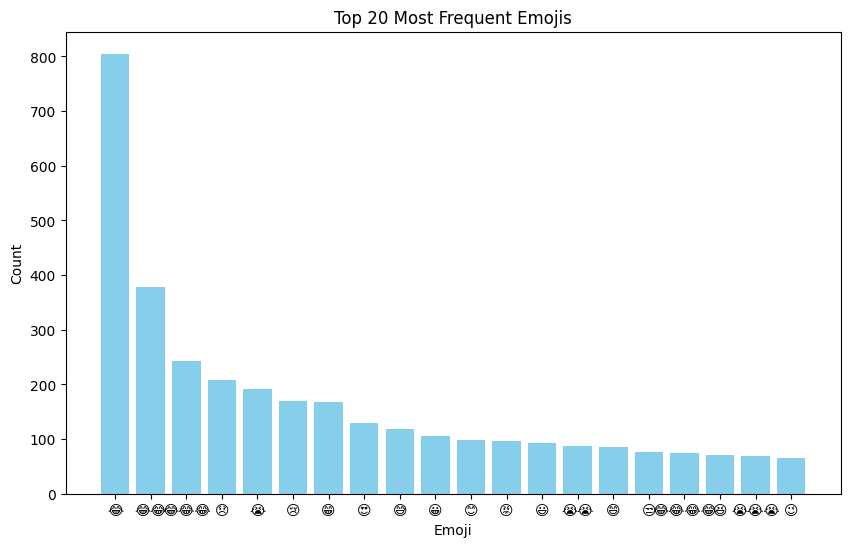

In [ ]:
emoji_df = pd.DataFrame(emoji_counts.items(), columns=['emoji', 'count'])

# Sort the DataFrame by count in descending order
emoji_df = emoji_df.sort_values(by='count', ascending=False)

# Plot the top 10 most frequent emojis
plt.figure(figsize=(10, 6))
plt.bar(emoji_df['emoji'][:20], emoji_df['count'][:20], color='skyblue')
plt.xlabel('Emoji')
plt.ylabel('Count')
plt.title('Top 20 Most Frequent Emojis')
plt.show()

In [ ]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters, numbers, and punctuations (except for hashtags and @mentions)
    text = re.sub("[^a-zA-Z#@]", " ", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    exclude =string.punctuation
    words = [word for word in words if word not in exclude]

    # Lemmatize words based on POS tags
    lemmatizer = WordNetLemmatizer()
    tagged_words = pos_tag(words)
    lemmatized_words = []
    for word, tag in tagged_words:
        if tag.startswith('NN'):  # Noun
            pos = 'n'
        elif tag.startswith('VB'):  # Verb
            pos = 'v'
        elif tag.startswith('JJ'):  # Adjective
            pos = 'a'
        else:
            pos = 'n'  # Default to noun
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))
    text = ' '.join(lemmatized_words)
    return text


In [ ]:
data['turn1_clean'] = data['turn1'].apply(preprocess_text)
data['turn2_clean'] = data['turn2'].apply(preprocess_text)
data['turn3_clean'] = data['turn3'].apply(preprocess_text)

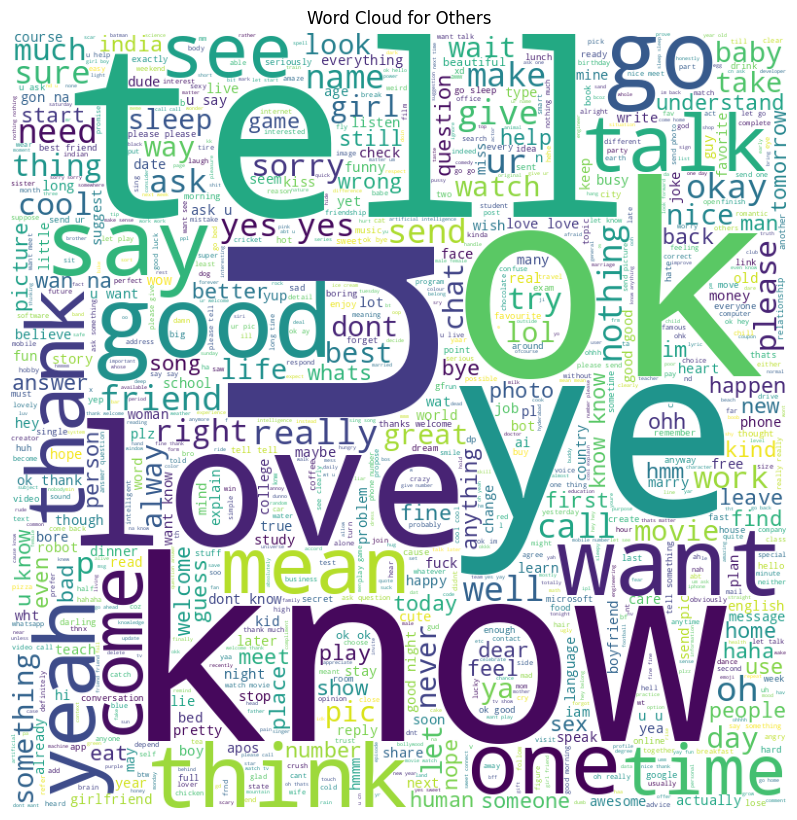

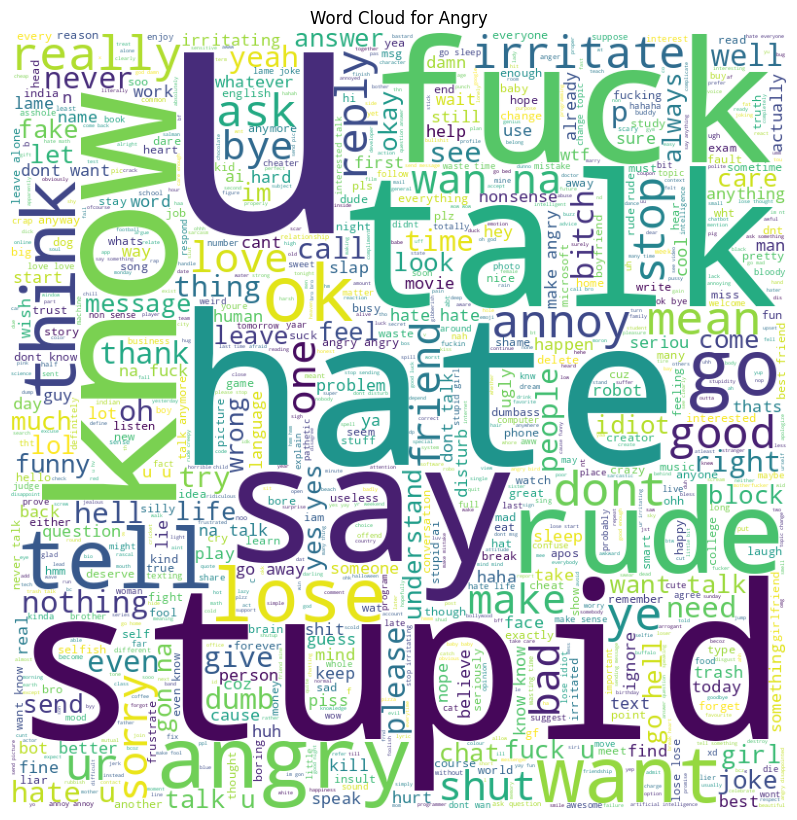

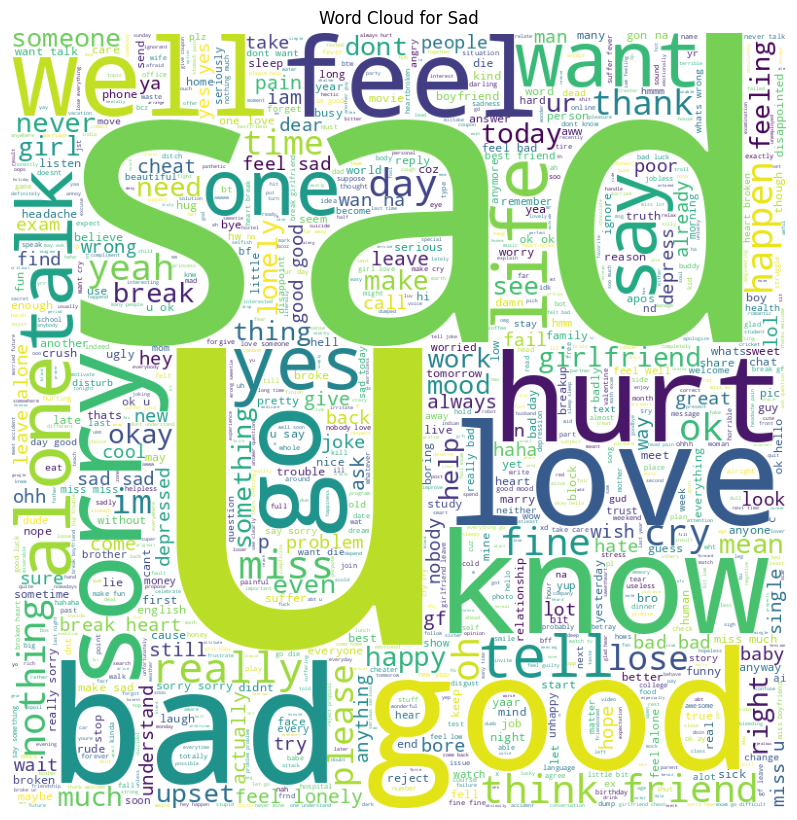

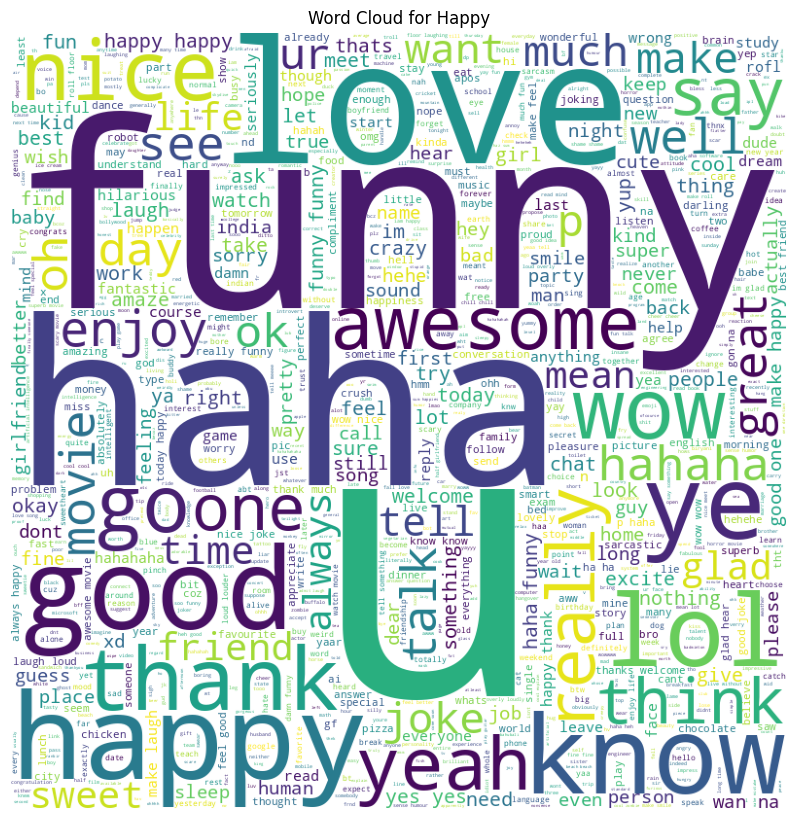

In [ ]:
data['clean_text'] = data['turn1_clean'] + ' ' + data['turn2_clean'] + ' ' + data['turn3_clean']

# Concatenate text for each label
text_label_others = ' '.join(data[data['label'] == 'others']['clean_text'].values)
text_label_angry = ' '.join(data[data['label'] == 'angry']['clean_text'].values)
text_label_sad = ' '.join(data[data['label'] == 'sad']['clean_text'].values)
text_label_happy = ' '.join(data[data['label'] == 'happy']['clean_text'].values)

# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=800, max_words=1000, background_color='white').generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

# Generate and display word clouds for each label
generate_word_cloud(text_label_others, 'Word Cloud for Others')
generate_word_cloud(text_label_angry, 'Word Cloud for Angry')
generate_word_cloud(text_label_sad, 'Word Cloud for Sad')
generate_word_cloud(text_label_happy, 'Word Cloud for Happy')

In [ ]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.7 MB/s eta 0:00:00


In [ ]:
import demoji

demoji.download_codes()


<ipython-input-55-610bed6913c2>:3: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
data['turn1_emojis_description'] = data['turn1_emojis'].apply(lambda x: ' '.join(demoji.findall(' '.join(x)).values()) if x else '')

In [ ]:
data['turn2_emojis_description'] = data['turn2_emojis'].apply(lambda x: ' '.join(demoji.findall(' '.join(x)).values()) if x else '')

In [ ]:
data['turn3_emojis_description'] = data['turn3_emojis'].apply(lambda x: ' '.join(demoji.findall(' '.join(x)).values()) if x else '')

In [ ]:
print(f'There are around {int(data["clean_text"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 450 duplicated tweets, we will remove them.


In [ ]:
data.drop_duplicates("clean_text", inplace=True)

In [ ]:
data['label'].value_counts()

label
others    14788
angry      5425
sad        5322
happy      4175
Name: count, dtype: int64

In [ ]:
data['emojis_description'] = data['turn1_emojis_description'] + ' ' + data['turn2_emojis_description'] + ' ' + data['turn3_emojis_description']

In [ ]:
data['emojis_description'].apply(preprocess_text)

0                       
1                       
2                       
3                       
4                       
              ...       
30155                   
30156    loudly cry face
30157                   
30158                   
30159                   
Name: emojis_description, Length: 29710, dtype: object

In [ ]:
data['combined_text'] = data['clean_text'] + ' ' + data['emojis_description']

In [ ]:
data['text_len'] = [len(text.split()) for text in data.combined_text]

In [ ]:
data.sort_values(by=['text_len'], ascending=False)

,id,turn1,turn2,turn3,label,turn1_emojis,turn2_emojis,turn3_emojis,turn1_clean,turn2_clean,turn3_clean,clean_text,text_len,turn1_emojis_description,turn2_emojis_description,turn3_emojis_description,emojis_description,combined_text
21328,21328,What is your phone 😬,I don't know because no one ever calls me.,Is it just seems like the way I can get it to ...,others,[😬],[],[],phone,know one ever call,seem like way get next week week send back nic...,phone know one ever call seem like way get nex...,61,grimacing face,,,grimacing face,phone know one ever call seem like way get nex...
20514,20514,"When their enemies were at the gates, the Roma...","Unfortunately, there was probably no one who w...",ou know what I've noticed? Nobody panics when ...,others,[],[],[],enemy gate roman would suspend democracy appoi...,unfortunately probably one would take complain...,ou know notice nobody panic thing go accord pl...,enemy gate roman would suspend democracy appoi...,61,,,,,enemy gate roman would suspend democracy appoi...
8265,8265,💗💖💝good to love you😊😃😘😍,😊😊😊 💕😄 wat is waiting fr me... Telll tell,😍😘,others,"[💗💖💝, 😊😃😘😍]","[😊😊😊, 💕😄]",[😍😘],good love,wat wait fr telll tell,,good love wat wait fr telll tell,52,smiling face with heart-eyes growing heart smi...,two hearts smiling face with smiling eyes grin...,face blowing a kiss smiling face with heart-eyes,smiling face with heart-eyes growing heart smi...,good love wat wait fr telll tell smiling face...
8978,8978,See... they way you answer is the very proof y...,I know you're an alien.,"You can never give straight answers, right? I ...",others,[],[],[],see way answer proof intellect human reason al...,know alien,never give straight answer right know reason p...,see way answer proof intellect human reason al...,50,,,,,see way answer proof intellect human reason al...
6454,6454,you very funny,Everyone knows I'm funny. B-),😜😜😜😜😜😝😝😝😝😛😛😛😛😎😎😎😎😘😘😘😘😻😻👉👉👉👉👉👉👉💋💋💋👄👫👫👫👫👫👫👫👫👭👬💑💑...,happy,[],[],[😜😜😜😜😜😝😝😝😝😛😛😛😛😎😎😎😎😘😘😘😘😻😻👉👉👉👉👉👉👉💋💋💋👄👫👫👫👫👫👫👫👫👭👬💑...,funny,everyone know funny b,,funny everyone know funny b,49,,,squinting face with tongue mouth woman and man...,squinting face with tongue mouth woman and m...,funny everyone know funny b squinting face ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29635,29635,No... You are not,And they shouldn't be.,Fuck!!!,angry,[],[],[],,,fuck,fuck,1,,,,,fuck
27761,27761,. .??,what :p,What do you ...??,others,[],[],[],,p,,p,1,,,,,p
16826,16826,What is it?,and leavin on?,Where?,others,[],[],[],,leavin,,leavin,1,,,,,leavin
22231,22231,But what,tHe SoNg,Which,others,[],[],[],,song,,song,1,,,,,song


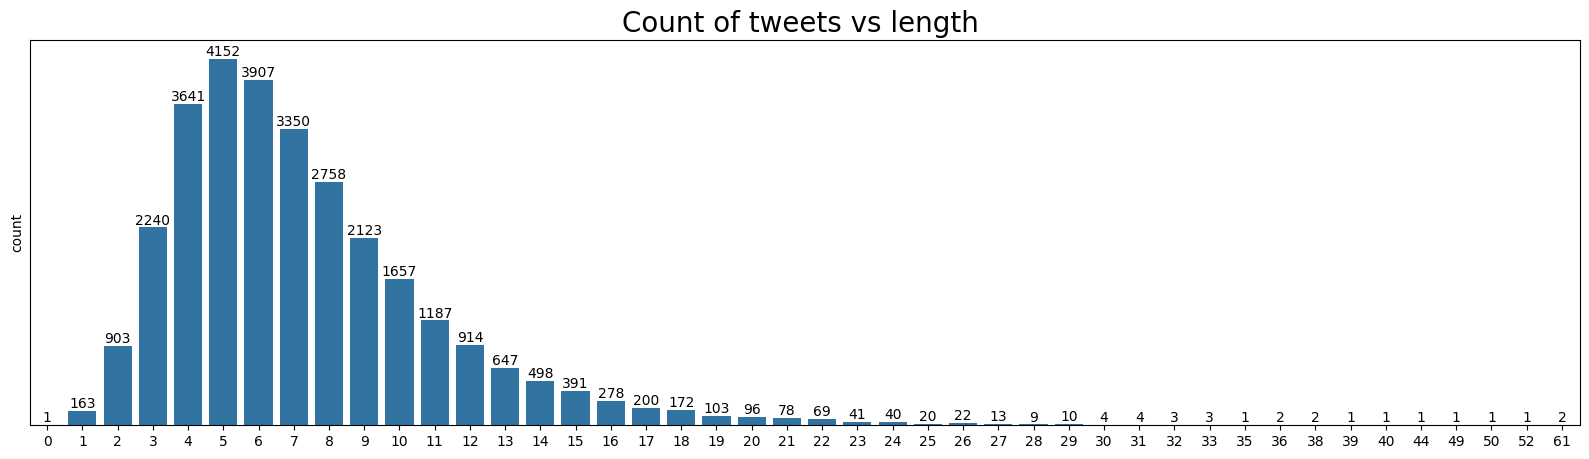

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='text_len', data=data[data['text_len']<=1000])
plt.title('Count of tweets vs length ', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
X = data['combined_text']
y = data['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

In [ ]:
X_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

In [ ]:
evaluation_dict={}

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.7997307303938068


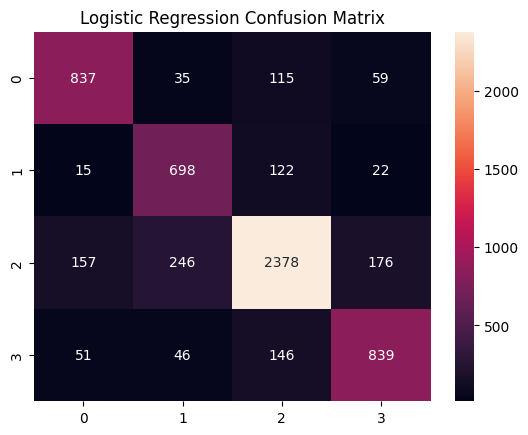

              precision    recall  f1-score   support

       angry       0.79      0.80      0.79      1046
       happy       0.68      0.81      0.74       857
      others       0.86      0.80      0.83      2957
         sad       0.77      0.78      0.77      1082

    accuracy                           0.80      5942
   macro avg       0.77      0.80      0.78      5942
weighted avg       0.81      0.80      0.80      5942

LogisticRegression(C=1, class_weight='balanced', random_state=42)


In [ ]:
lr = LogisticRegression(random_state=42)

# Define the hyperparameters to tune
parameters = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(lr, param_grid=parameters, cv=5, n_jobs=-1)

grid_search.fit(X_tfidf, y_train)
logistic_predictions = grid_search.best_estimator_.predict(X_test_tf)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print(f'Logistic Regression Accuracy: {logistic_accuracy}')

# Confusion Matrix
logistic_cm = confusion_matrix(y_test, logistic_predictions)
sns.heatmap(logistic_cm, annot=True, fmt='d')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

print(classification_report(y_test, logistic_predictions))
print(grid_search.best_estimator_)

Random Forest Accuracy: 0.8108381016492764


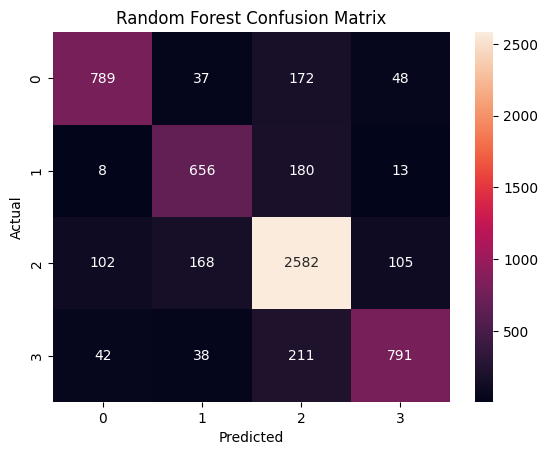

              precision    recall  f1-score   support

       angry       0.84      0.75      0.79      1046
       happy       0.73      0.77      0.75       857
      others       0.82      0.87      0.85      2957
         sad       0.83      0.73      0.78      1082

    accuracy                           0.81      5942
   macro avg       0.80      0.78      0.79      5942
weighted avg       0.81      0.81      0.81      5942



In [ ]:
rf = RandomForestClassifier(random_state=42)

# Fit the model
rf.fit(X_tfidf, y_train)

# Make predictions
rf_predictions = rf.predict(X_test_tf)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Random Forest Accuracy: {rf_accuracy}')

# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(rf_cm, annot=True, fmt='d')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(y_test, rf_predictions))

Gradient Boosting Accuracy: 0.81167956916863



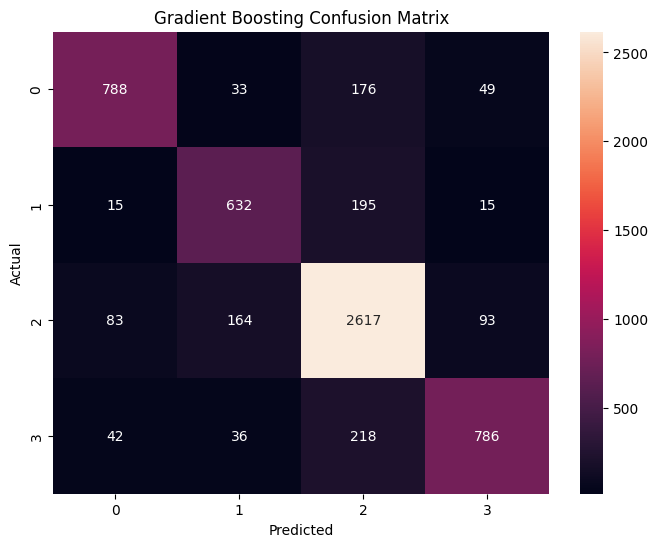

Classification Report:
              precision    recall  f1-score   support

       angry       0.85      0.75      0.80      1046
       happy       0.73      0.74      0.73       857
      others       0.82      0.89      0.85      2957
         sad       0.83      0.73      0.78      1082

    accuracy                           0.81      5942
   macro avg       0.81      0.78      0.79      5942
weighted avg       0.81      0.81      0.81      5942


Best Estimator:
GradientBoostingClassifier(max_depth=5, n_estimators=500, random_state=42)


In [ ]:
gb = GradientBoostingClassifier(random_state=42, n_estimators=500, max_depth=5)

# Fit the model
gb.fit(X_tfidf, y_train)

# Make predictions using the trained model
gb_predictions = gb.predict(X_test_tf)

# Evaluate performance
gb_accuracy = accuracy_score(y_test, gb_predictions)
print(f'Gradient Boosting Accuracy: {gb_accuracy}\n')

# Confusion Matrix
gb_cm = confusion_matrix(y_test, gb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(gb_cm, annot=True, fmt='d')
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, gb_predictions))

# Print the best estimator
print('\nBest Estimator:')
print(gb)